In [1]:
from MSA.utils import MSAINFO
from MSA.utils import getHamiltonianDiag, PaulisIZDecomposition, draw_from_dict
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector
import numpy as np
from MSA.VQE_v4 import VQE
import os, pickle

## Initialization

In [2]:
seqs = ['AG', 'G']
# seqs = ['ACG', 'AG', 'A']

In [3]:
msa = MSAINFO(seqs, p=1)
msa.__dict__

{'seqs': ['AG', 'G'],
 'num_seqs': 2,
 'S': array([2, 1]),
 'L': 2,
 'encoding_dims': 4,
 'weights': {(0,
   1): array([[ 1.,  0.],
         [-1.,  0.]])},
 'p': 1}

## Get Hamiltonian

In [4]:
H = getHamiltonianDiag(msa)
Paulis_Decompsition = PaulisIZDecomposition(H)

In [5]:
if os.path.exists(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl'):
    with open(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl', 'rb') as f:
        Paulis_Decompsition = pickle.load(f)
else:
    with open(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl', 'wb') as f:
        pickle.dump(Paulis_Decompsition, f)

## Construct Ansatz

### QAOA Ansatz

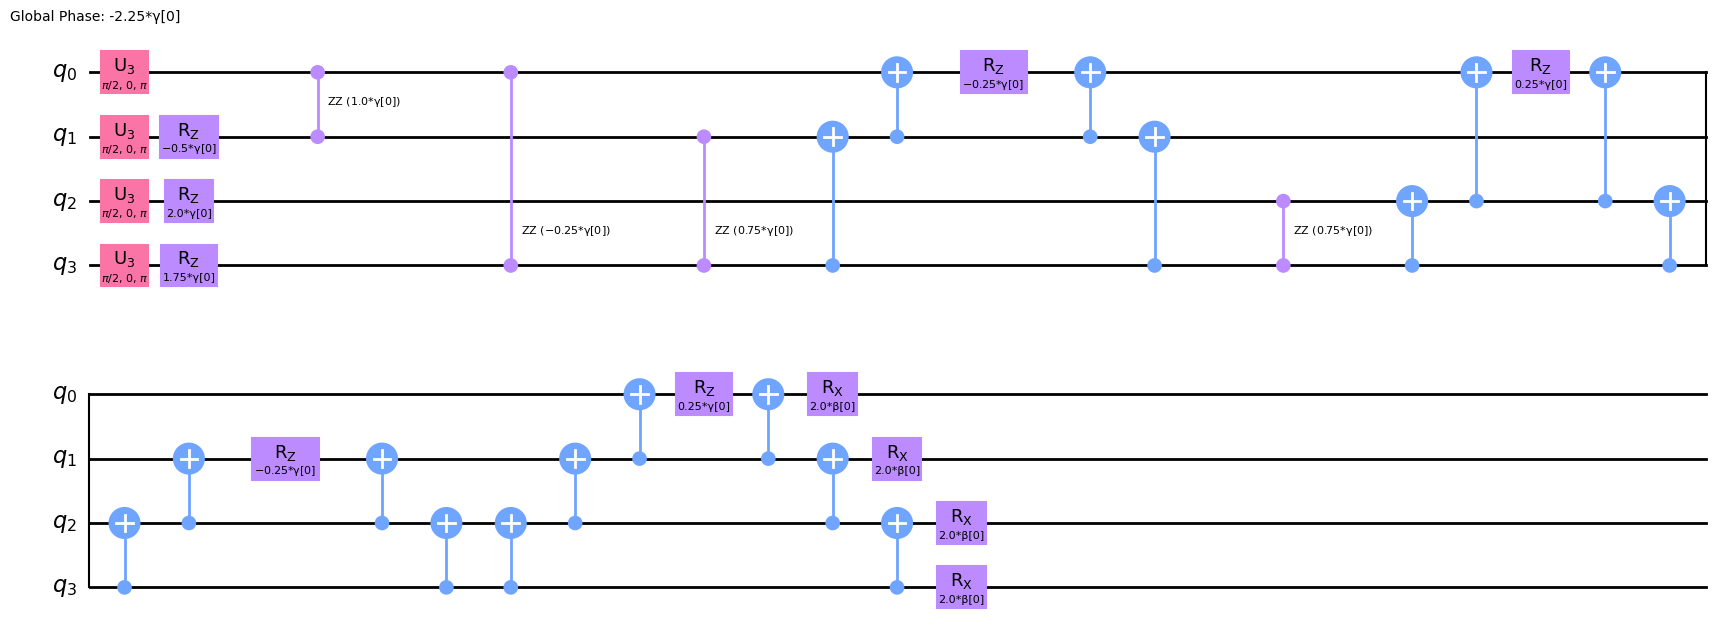

In [6]:
Hamiltonian = SparsePauliOp.from_list(list(Paulis_Decompsition.items()))
ansatz = QAOAAnsatz(Hamiltonian, reps=1)
ansatz = ansatz.decompose(reps=3)
ansatz.draw(output="mpl", style="iqp")

### Hardware Efficient Ansatz

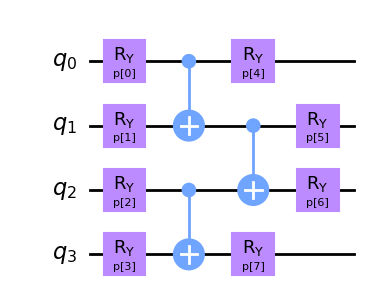

In [7]:
n_layers = 1
n_qubits = msa.encoding_dims
ansatz = QuantumCircuit(n_qubits)
pv = ParameterVector("p", (n_layers + 1) * n_qubits)
for i in range(n_qubits):
    ansatz.ry(pv[i], i)
for j in range(n_layers):
    for i in range(n_qubits // 2):
        ansatz.cnot(2*i, 2*i+1)
    if n_qubits % 2 == 0:
        for i in range(n_qubits // 2-1):
            ansatz.cnot(2*i+1, 2*i+2)
    else:
        for i in range(n_qubits // 2):
            ansatz.cnot(2*i+1, 2*i+2)
    for i in range(n_qubits):
        ansatz.ry(pv[(j+1)*n_qubits + i], i)
ansatz.draw(output="mpl", style="iqp")

## VQE

In [8]:
SHOTS = 5000
params = np.random.random(ansatz.num_parameters) * 0.1

In [9]:
vqe = VQE(ansatz, backend=None, nshots=SHOTS)
score, params = vqe.run(Hamiltonian, init_params=params, optimizer='adam', jac='spsa', c=0.02, maxiter=100, lr=1.0, isAdaptive=True, threshold=1e-15)
print(f' Score: {score}\n optimal parameter:\n {params}')

 Score: -0.9932000000000003
 optimal parameter:
 [ 3.12909124 -3.00287161  2.03139478  1.59148227  0.0190279   0.11013355
  1.1214762   1.63237386]


## Visualization

In [10]:
optimal_circuit = ansatz.bind_parameters(params)
optimal_circuit.measure_all()

In [17]:
backend = Aer.get_backend('qasm_simulator')
res = backend.run(optimal_circuit, shots=SHOTS).result()
counts = res.get_counts()
counts

{'0001': 1, '1001': 1, '0101': 1, '1011': 6, '1101': 4991}

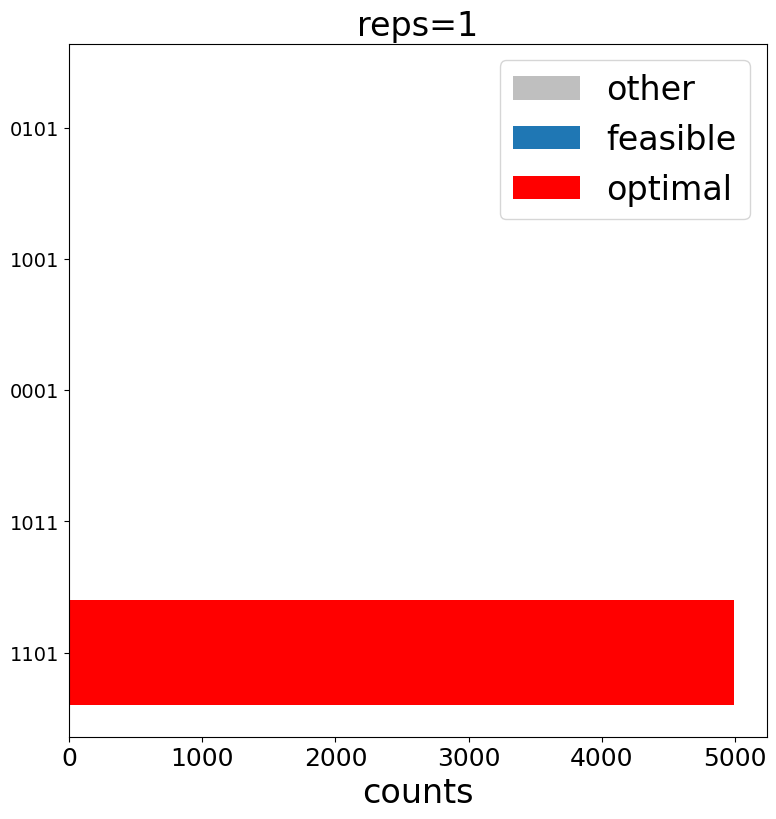

In [18]:
draw_from_dict(counts, ideal_state=['1101'], feasible_state=['1110'], reps=1, is_save=False, heng=1)